In [1]:
%matplotlib inline
import sys
# initialize stuff
if sys.platform == 'darwin':
    plat = 'usb'
    # plat = 'mac'
    sys.path.append('/Users/njchiang/GitHub/LanguageMVPA/multivariate/python/analysis')
    sys.path.append('/Users/njchiang/GitHub/python-fmri-utils/utils')
    debug = True
else:
    plat = 'win'
    sys.path.append('D:\\GitHub\\LanguageMVPA\\multivariate\\python\\analysis')
    sys.path.append('D:\\GitHub\\python-fmri-utils\\utils')
    debug = False
import lmvpautils as lmvpa
paths, subList, contrasts, maskList = lmvpa.initpaths(plat)

Initializing...


In [2]:
# parameters
sub = 'LMVPA005'
roi = "left_IFG_operc"
betatype = 'tstat'
con = "stim"
chance = .5
filterLen = 49
filterOrd = 2
dsType = "Lang"
nVox = 500

In [3]:
# load raw data
thisSub = {sub: subList[sub]}
mc_params = lmvpa.loadmotionparams(paths, thisSub)
beta_events = lmvpa.loadevents(paths, thisSub)
dsdict = lmvpa.loadsubdata(paths, thisSub, m=roi, c='trial_type')
thisDS = dsdict[sub]

loading LMVPA005


C:\Python27\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [4]:
# preprocess raw data
# sg filter takes care of autocorrelation
import SavGolFilter as sg
sg.sg_filter(thisDS, filterLen, filterOrd)
from mvpa2.mappers.zscore import zscore
zscore(thisDS, chunks_attr='chunks')

In [5]:
# beta extract raw data (LSA but with no prewhitening)
rds, events = lmvpa.amendtimings(thisDS.copy(), beta_events[sub], contrasts)  # adding features

import mvpa2.datasets.eventrelated as er
evds = er.fit_event_hrf_model(rds, events, time_attr='time_coords',
                              condition_attr=('trial_type', 'chunks'),
                              design_kwargs={'add_regs': mc_params[sub], 'hrf_model': 'canonical'},
                              return_model=True)
fds = lmvpa.replacetargets(evds, contrasts, con)
fds = fds[fds.targets != '0']

In [6]:
# load betas
lss = lmvpa.loadsubbetas(paths, sub, btype=betatype, method="LSS", m=roi)
lss = lmvpa.replacetargets(lss, contrasts, con)
lsa = lmvpa.loadsubbetas(paths, sub, btype=betatype, method="LSA", m=roi)
lsa = lmvpa.replacetargets(lsa, contrasts, con)

LMVPA005


LMVPA005


In [7]:
# preprocess betas
zscore(lss, chunks_attr='chunks')
zscore(lsa, chunks_attr='chunks')

# bds.sa['targets'] = bds.sa[con]

In [8]:
# set analysis idx
# flidx = fds.chunks < fds.sa['chunks'].unique[len(fds.sa['chunks'].unique)/2]
# fpidx = fds.chunks >= fds.sa['chunks'].unique[len(fds.sa['chunks'].unique) / 2]
# blidx = bds.sa['stim'].value == 's'
fds = lmvpa.sortds(fds)
lsa = lmvpa.sortds(lsa)
lss = lmvpa.sortds(lss)
flidx = fds.chunks == fds.chunks
lssidx = lss.chunks == lss.chunks

['2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '0' '0' '0' '0'
 '0' '0' '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


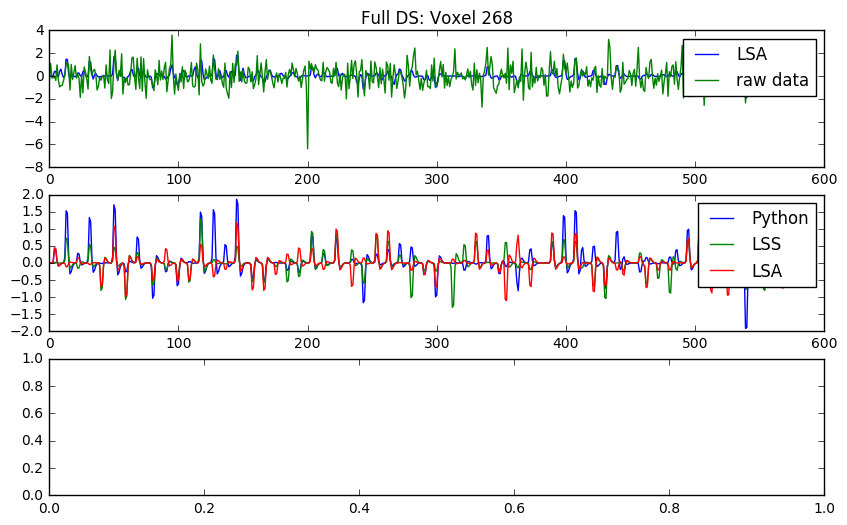

In [9]:
# beta extraction QC
import numpy as np
import matplotlib.pyplot as plt
iVox = np.random.randint(0, rds.shape[1])

print evds.sa.targets
regidx = evds.sa.targets == evds.sa.targets
# regidx = evds.sa.targets == '0'
# plt.plot(evds.sa.regressors.T[:,regidx])
f, axarr = plt.subplots(3, figsize=(10,6))
axarr[0].plot(np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox], label='LSA')
# plt.plot(np.dot(evds.sa.regressors.T[:, regidx], bds.samples[]))[:,iVox] # get these in right order
axarr[0].plot(rds.samples[:, iVox], label='raw data')
axarr[0].legend()
axarr[0].set_title('Full DS: Voxel ' + str(iVox))
axarr[1].plot(np.dot(fds.sa.regressors.T, fds.samples)[:, iVox], label='Python')
axarr[1].plot(np.dot(fds.sa.regressors.T, lss.samples)[:, iVox], label='LSS')
axarr[1].plot(np.dot(fds.sa.regressors.T, lsa.samples)[:, iVox], label='LSA')
axarr[1].legend()
plt.show()
# print np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox].shape
# print rds[:,iVox].samples.shape
# np.corrcoef(np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox], 
#             rds.samples[:,iVox])
# print (np.mean(rds, axis=0), np.std(rds, axis=0))

In [10]:
# initialize classifier
from mvpa2.clfs import svm
clf = svm.LinearCSVMC()
from mvpa2.clfs.warehouse import OneWayAnova
fsel = OneWayAnova()
import mvpa2.featsel as fs
fselector = fs.helpers.FixedNElementTailSelector(nVox, tail='upper',
                                                 mode='select', sort=False)
# fselector = fs.helpers.FractionTailSelector(0.05, mode='select', tail='upper')
sbfs = fs.base.SensitivityBasedFeatureSelection(fsel, fselector,
                                                enable_ca=['sensitivities'])
from mvpa2.clfs.meta import FeatureSelectionClassifier
fclf = FeatureSelectionClassifier(clf, sbfs)

from mvpa2.measures.base import CrossValidation
from mvpa2.misc import errorfx
from mvpa2.generators.partition import NFoldPartitioner
cv = CrossValidation(fclf,
                     NFoldPartitioner(attr='chunks'),
                     errorfx=errorfx.mean_match_accuracy)

In [11]:
#SVM
import numpy as np
lsares = cv(lsa[lssidx].copy())
print "lsa mean: " + str(np.mean(lsares))
cv.untrain()
lssres = cv(lss[lssidx].copy())
print "lss mean: " + str(np.mean(lssres))
cv.untrain()
fres = cv(fds[flidx].copy())
print "from raw mean: " + str(np.mean(fres))

lsa mean: 0.0
lss mean: 0.0


from raw mean: 0.46875


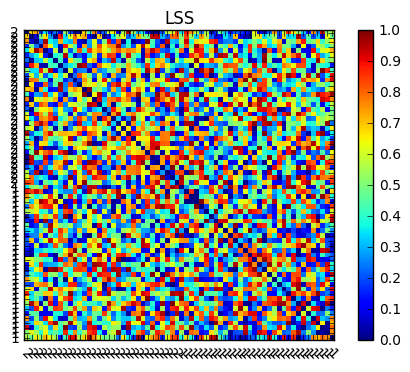

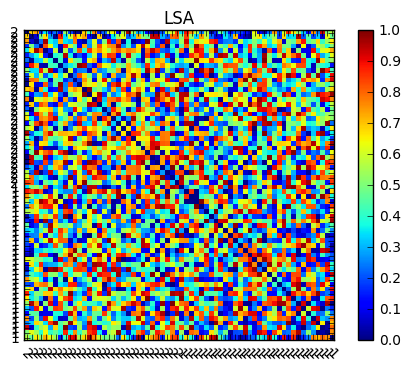

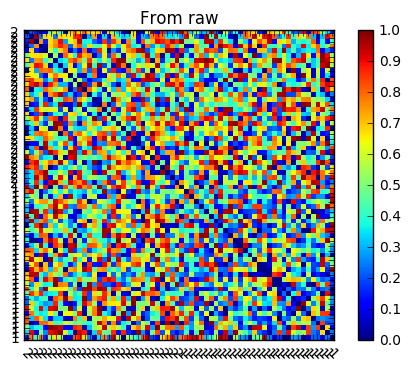

In [12]:
from mvpa2.measures import rsa
dsm = rsa.PDist(square=True)
frsares = dsm(fds[flidx].copy())
lssrsares = dsm(lss[lssidx].copy())
lsarsares = dsm(lsa[lssidx].copy())
import rsautils as ru
lssf, lssax = ru.plot_mtx(ru.rankTransform(lssrsares), lss[lssidx].sa.targets, 'LSS', vmin=0, vmax=1)
lsaf, lsaax = ru.plot_mtx(ru.rankTransform(lsarsares), lsa[lssidx].sa.targets, 'LSA', vmin=0, vmax=1)
ff, fax = ru.plot_mtx(ru.rankTransform(frsares), fds[flidx].sa.targets, 'From raw', vmin=0, vmax=1)

In [28]:
print bds.sa.trial_type
print fds.sa.trial_type

['l_Console_Anim_Act_Can' 'l_Console_Anim_Act_Rel'
 'l_Console_Anim_Pass_Can' 'l_Console_Anim_Pass_Rel'
 'l_Crush_Inanim_Act_Can' 'l_Crush_Inanim_Act_Rel'
 'l_Crush_Inanim_Pass_Can' 'l_Crush_Inanim_Pass_Rel' 'l_Hit_Inanim_Act_Can'
 'l_Hit_Inanim_Act_Rel' 'l_Hit_Inanim_Pass_Can' 'l_Hit_Inanim_Pass_Rel'
 'l_Kick_Anim_Act_Can' 'l_Kick_Anim_Act_Rel' 'l_Kick_Anim_Pass_Can'
 'l_Kick_Anim_Pass_Rel' 'l_Kiss_Anim_Act_Can' 'l_Kiss_Anim_Act_Rel'
 'l_Kiss_Anim_Pass_Can' 'l_Kiss_Anim_Pass_Rel' 'l_Light_Inanim_Act_Can'
 'l_Light_Inanim_Act_Rel' 'l_Light_Inanim_Pass_Can'
 'l_Light_Inanim_Pass_Rel' 'l_Stretch_Anim_Act_Can'
 'l_Stretch_Anim_Act_Rel' 'l_Stretch_Anim_Pass_Can'
 'l_Stretch_Anim_Pass_Rel' 'l_Touch_Inanim_Act_Can'
 'l_Touch_Inanim_Act_Rel' 'l_Touch_Inanim_Pass_Can'
 'l_Touch_Inanim_Pass_Rel' 's_Console_Anim_Act_Can'
 's_Console_Anim_Act_Rel' 's_Console_Anim_Pass_Can'
 's_Console_Anim_Pass_Rel' 's_Crush_Inanim_Act_Can'
 's_Crush_Inanim_Act_Rel' 's_Crush_Inanim_Pass_Can'
 's_Crush_Inanim_Pass

In [24]:
# scratch
frsares
bds.sa.stim

array(['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], 
      dtype='|S1')

In [14]:
### DON'T RUN THESE, THEY WERE FOR MAKING THE LSA REGRESSORS### 
def addLSARegressors(sub):
    import os
    import pandas as pd
    import numpy as np
    projectDir = 'D:\\fmri\\LanguageMVPA'
    lssFile = pd.read_csv(os.path.join(projectDir, 'data', sub, 'func', sub + '_LSS_betas.tsv'), sep='\t')
    df = pd.read_csv(os.path.join(projectDir, 'data', 'LSA_betas.tsv'), sep='\t')
    ofname = os.path.join(projectDir, 'data', sub, 'func', sub + '_LSA_betas.tsv')
    # print os.listdir(os.path.join(projectDir, 'data'))
    # lssFile['trial_type'].tolist()
    b = {}
    for i, t in enumerate(lssFile['trial_type']):
        b[t] = lssFile['run'].tolist()[i]
        
    r = []
    for i in df['trial_type']:
        r.append(b[i])
        
    df['run'] = pd.Series(r, index=df.index)    
    df.to_csv(ofname, sep='\t', index=False)

[addLSARegressors(s) for s in subList.keys()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]